<a href="https://colab.research.google.com/github/mc2engel/afraid-to-commit/blob/master/What_is_going_on_with_gradients_in_JAX_MD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Imports and utils


In [ ]:
#%%capture
!pip install tfp-nightly[jax]
!pip install -U jax-md
!pip install -U distrax
!pip install -U optax

In [67]:
#import jax.tools.colab_tpu
#jax.tools.colab_tpu.setup_tpu()
import jax
import jax.numpy as jnp
import optax
from jax import lax
from jax import random, jit, vmap, grad, value_and_grad
import numpy as np
import distrax
import tensorflow_probability as tfp
from jax.example_libraries import optimizers as jopt
import os
import functools
import pickle

import tqdm
import time
from google.colab import files
import numpy as onp

import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib import rc
import pandas as pd
import seaborn as sns
rc('animation', html='jshtml')

#from google.colab import drive
#drive.mount('/content/drive')

# Basic Monte Carlo Simulation


The crux of an MC simulation is an 'if'-statement decision point where the code adopts one trajectory or another on the basis of a random number draw. To consider how this affects backpropagating through such simulations, consider a minimal MC code example -- the Ferromagnetic Ising model, with Hamiltonian

$E = - \sum_{NN} J_{ij} \sigma_i\sigma_j$

where the sum is taken over nearest neighbors and there is no external field. We will consider the problem of simply minimizing the energy (which occurs for T=0, but we will at least get an idea of whether our gradients are pointing in the right direction).

To minimize the energy, we'll set $J_{ij} = k_B = 1$ and:

1. Run $n$ MC simulations of an NxN Ising lattice at temperature $T_{guess}$. Use the Glauber spin flip probability $P = \frac{e^{-dE/T}}{1 + e^{-dE/T}}$.
2. Compute $<E>$ and $\nabla_T<E>$ over #the batch.
3. Perform a step of gradient descent.
4. Repeat until desired gradient tolerance is reached.
5. See if gradient behaviour makes sense.



In [7]:
@jit
def periodic_lattice(index, s):
    """returns periodic lattice index 
    for a given iterable index"""
    return (index%s + s)%s


@jit
def choose_spin(key, N):
  uni=distrax.Uniform(low=0.0, high=N**2)
  spin=jnp.floor(uni.sample(seed=key)).astype(int)
  #return jax.random.randint(key, [], 0, N**2)
  return spin

@jit
def sum_neighbors(spins: jnp.array) -> jnp.array:
  """Sum over the neighbors of each point in a periodic grid."""
  ndim = spins.ndim
  rolled = []
  for axis in range(ndim):
    for shift in [-1, 1]:
      rolled.append(jnp.roll(spins, shift, axis))
  return sum(rolled)

@jit
def lattice_energy(spins: jnp.array) -> jnp.float64:
  """return lattice energy."""
  return 0.5*jnp.sum(-1 * spins * sum_neighbors(spins))

def simulate_MC(key, T, N, steps):
  def _step(lattice_, key):
    key, split = jax.random.split(key, 2)
    k = choose_spin(key, N)
    spinval = lattice_[periodic_lattice(jnp.floor(k/N).astype(int),N)][periodic_lattice(k%N-1,N)]
    dE = 2. * spinval * sum_neighbors(lattice_)[periodic_lattice(jnp.floor(k/N).astype(int),N)][periodic_lattice(k%N-1,N)]
    prob = jnp.exp(-(1.0/T)*dE)/(1+jnp.exp(-(1.0/T)*dE)) #glauber spin flip probability
    flip_dist = distrax.Bernoulli(probs=prob)
    flip = flip_dist.sample(seed=split)
    lattice_ = lattice_.at[periodic_lattice(jnp.floor(k/N).astype(int),N),periodic_lattice(k%N-1,N)].set((1.-2.*flip)*spinval)
    dE = flip*dE
    return lattice_, flip
  key, split, = jax.random.split(key, 2)
  init_lattice = jax.random.randint(key, (N, N), 0, 2)*2-1
  seeds = jax.random.split(split, steps)
  #final_state, dEs = jax.lax.scan(_step, lattice, seeds)
  return jax.lax.scan(_step, init_lattice, seeds)


In [18]:
def setup_loss(key, N, steps, batch):
  def loss(T):
      mapped_sim = vmap(simulate_MC, [0, None, None, None])
      mapped_energy = vmap(lattice_energy, [0])
      seeds = random.split(key, batch)
      results, _ = mapped_sim(seeds, T, N, steps)
      energies = mapped_energy(results)
      return jnp.mean(energies)
  return loss



def get_train_step(optimizer,
                   lattice_size: int,
                   batch_size: int,
                   time_steps: int,
                   loss_function):
    @jax.jit
    def train_step(state, j):
        Eavg, gradE = value_and_grad(loss_function)(T)
        opt_state = optimizer.update_fn(j, gradE, state)
        return opt_state, (Eavg, gradE)
    return train_step

key = random.PRNGKey(0)
N=8 #lattice size
T = 150.
steps = 10*N**2
training_steps = 10
batch = 10
optimizer = jopt.adam(.01)
init_state = optimizer.init_fn(T)

loss = setup_loss(key, N, steps, batch)
update_fn = get_train_step(optimizer, N, batch, steps, loss)
state = optimizer.init_fn(T)
grads = []
Es = []
for j in tqdm.trange(training_steps, position=0):
  key, split = random.split(key, 2)
  state, (E, gradE) = update(state, j)
  Es.append(E)
  grads.append(gradE)

  0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/distrax/_src/utils/conversion.py:143: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return x.astype(jnp.float_)
/usr/local/lib/python3.7/dist-packages/jax/_src/ops/scatter.py:90: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32. In future JAX releases this will result in an error.
  FutureWarning)
100%|██████████| 10/10 [00:02<00:00,  3.87it/s]


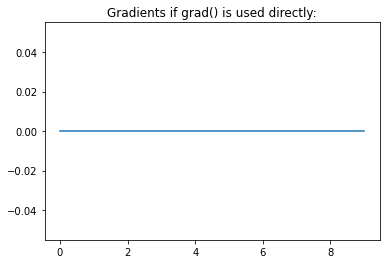

In [19]:
plt.title("Gradients if grad() is used directly:")
plt.plot(grads)

Okay, so the gradients are identically 0! This reveals the problem with grad() + MC simulations: we *know* that E depends on T, but the dependence doesn't enter explicitly: it enters through the spin flip probability p(T). 

The *correct* way to deal with gradients in cases like this is as follows:

\begin{equation}
    \langle E\rangle = \int \mathcal{D}{x}(t) p[{x}(t), {T}] E[{x}(t)]
\end{equation}

Where $\langle E({T})\rangle$ is the average energy at temperature T, $\int\mathcal{D}{x}(t)$ is an intergral over every possibly simulation trajectory, $p[{x}(t), {T}]$ is the probability of one particular simulation realization ${x}(t)$ at temperature $T$, and $E[{x}(t)]$ is the energy of that particular simulation realization.

We seek $\nabla_T \langle E({T})\rangle$. To get it, bring the gradient inside the integral and use the product rule:

\begin{equation}
    \nabla_{T} \langle E({T})\rangle = \int \mathcal{D}{x}(t) (\nabla_{{T}} p) E + p (\nabla_{{T}} E) \\
    = \int \mathcal{D}{x}(t) (p \nabla_{{T}} \ln p) E + p (\nabla_{{T}} E) \\
    = \langle (\nabla_{{T}} \ln p) E \rangle + \langle \nabla_{{T}} E \rangle
\end{equation}

The latter term, $\nabla_{{T}} E $, is 0, as we've just seen: the energy has no explicit dependence on temperature. So, we need to compute $\nabla_{{T}} \ln p$ for each trajectory and then perform an ensemble average.


In [20]:
#modify the simulation function to also return the log prob of a particular simulation trajectory, then average over many gradient estimates:

def simulate_MC_lnp(T, N, steps, key):
  def _step(lattice_, key):
    key, split = jax.random.split(key, 2)
    k = choose_spin(key, N)
    spinval = lattice_[periodic_lattice(jnp.floor(k/N).astype(int),N)][periodic_lattice(k%N-1,N)]
    dE = 2. * spinval * sum_neighbors(lattice_)[periodic_lattice(jnp.floor(k/N).astype(int),N)][periodic_lattice(k%N-1,N)]
    prob = jnp.exp(-(1.0/T)*dE)/(1+jnp.exp(-(1.0/T)*dE))
    flip_dist = distrax.Bernoulli(probs=prob)
    flip = flip_dist.sample(seed=split)
    logprob = flip_dist.log_prob(flip)
    lattice_ = lattice_.at[periodic_lattice(jnp.floor(k/N).astype(int),N),periodic_lattice(k%N-1,N)].set((1.-2.*flip)*spinval)
    dE = flip*dE
    return lattice_, logprob
  key, split, = jax.random.split(key, 2)
  init_lattice = jax.random.randint(key, (N, N), 0, 2)*2-1
  seeds = jax.random.split(split, steps)
  #final_state, dEs = jax.lax.scan(_step, lattice, seeds)
  return jax.lax.scan(_step, init_lattice, seeds)

def estimate_gradient(loss_function):
  """Estimates gradients using reverse-mode differentiation.
  This is faster than `estimate_gradient_fwd` but consumes much more memory.
  """
  @functools.partial(grad, has_aux=True)
  def _estimate_gradient(T,
                         N: int,
                         simlength: int,
                         seed: jnp.array):
    final_lattice, logprob = simulate_MC_lnp(T, N, steps, seed)
    trajectory_log_prob = logprob.sum()
    loss = loss_function(final_lattice)
    gradient_estimator = trajectory_log_prob * jax.lax.stop_gradient(loss) + loss #we don't really need the second term, since we've seen the grad is 0
    return gradient_estimator, loss#trajectory_log_prob
  return _estimate_gradient

def get_train_step_lnp(optimizer: jopt.Optimizer,
                   lattice_size: int,
                   batch_size: int,
                   time_steps: int,
                   loss_function):
  gradient_estimator = estimate_gradient(loss_function)
  mapped_gradient_estimate = vmap(gradient_estimator, [None, None, None, 0])
  @jax.jit
  def _train_step(state, j, seed):
    seeds = jax.random.split(seed, batch_size)
    T = optimizer.params_fn(state)
    grads, Eavg = mapped_gradient_estimate(T, N, time_steps, seeds)
    mean_grad = jax.tree_map(lambda x: jnp.mean(x, 0), grads)
    opt_state = optimizer.update_fn(j, mean_grad, state)
    return opt_state, (Eavg.sum(), mean_grad)
  return _train_step

In [23]:
key = random.PRNGKey(0)
N = 8 #lattice size
T = 10.
steps = 100*N**2
training_steps = 50
batch = 1000
#lr = jopt.exponential_decay(0.1, training_steps, .01)
lr=0.1
optimizer = jopt.adam(lr)
init_state = optimizer.init_fn(T)

update = get_train_step_lnp(optimizer, N, batch, steps, lattice_energy)
state = optimizer.init_fn(T)
grads = []
Es = []
states=[]
for j in tqdm.trange(training_steps, position=0):
  key, split = random.split(key, 2)
  state, (E, gradE) = update(state, j, key)
  Es.append(E)
  grads.append(gradE)
  states.append(optimizer.params_fn(state))

100%|██████████| 50/50 [00:30<00:00,  1.65it/s]


This yields nonzero gradients:

1.6562847


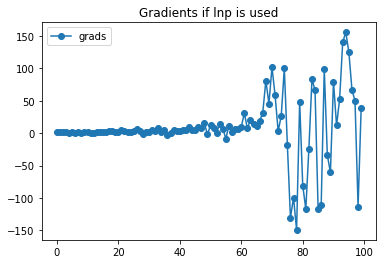

In [ ]:
plt.title("Gradients if lnp is used")
#print(Es)
plt.plot(grads, 'o-', label='grads')
#plt.plot(Es, 'o',label='energies')
plt.legend()

print(np.mean(grads[0:20]))

And we can confirm that the temperature is being driven in the correct direction:

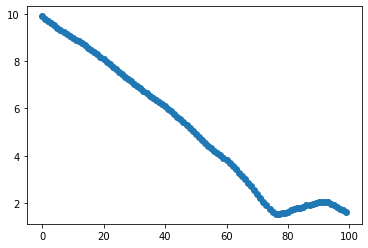

In [ ]:
plt.plot(states, 'o')

#Brownian dynamics simulation

In [69]:
import jax_md as jmd
import collections 
from tensorflow_probability.substrates import jax as tfp
from functools import partial

tfd = tfp.distributions

class BrownianState(collections.namedtuple('BrownianState',
                                           'position mass rng log_prob')):
  pass

def brownian(energy_or_force,
             shift,
             dt,
             kT,
             gamma=0.1):
  """Simulation of Brownian dynamics.
  This code simulates Brownian dynamics which are synonymous with the overdamped
  regime of Langevin dynamics. However, in this case we don't need to take into
  account velocity information and the dynamics simplify. Consequently, when
  Brownian dynamics can be used they will be faster than Langevin. As in the
  case of Langevin dynamics our implementation follows [1].
  Args:
    energy_or_force: A function that produces either an energy or a force from
      a set of particle positions specified as an ndarray of shape
      [n, spatial_dimension].
    shift_fn: A function that displaces positions, R, by an amount dR. Both R
      and dR should be ndarrays of shape [n, spatial_dimension].
    dt: Floating point number specifying the timescale (step size) of the
      simulation.
    T_schedule: Either a floating point number specifying a constant temperature
      or a function specifying temperature as a function of time.
    quant: Either a quantity.Energy or a quantity.Force specifying whether
      energy_or_force is an energy or force respectively.
    gamma: A float specifying the friction coefficient between the particles
      and the solvent.
  Returns:
    See above.
    [1] E. Carlon, M. Laleman, S. Nomidis. "Molecular Dynamics Simulation."
        http://itf.fys.kuleuven.be/~enrico/Teaching/molecular_dynamics_2015.pdf
        Accessed on 06/05/2019.
  """

  force_fn = jmd.quantity.canonicalize_force(energy_or_force)

  #dt, gamma = jmd.util.static_cast(dt, gamma)

  T_schedule = jmd.interpolate.canonicalize(kT)

  def _dist(state, t, **kwargs):
    nu = jnp.float32(1) / (state.mass * gamma)
    F = force_fn(state.position, t=t, **kwargs)
    mean =  F * nu * dt
    variance = jnp.float32(2) * T_schedule(t) * dt * nu
    return tfd.Normal(mean, jnp.sqrt(variance))
  
  def init_fn(key, R, mass=jnp.float32(1)):
    #mass = jmd.quantity.canonicalize_mass(mass)
    return BrownianState(R, mass, key, 0.)

  def apply_fn(state, t=jnp.float32(0), **kwargs):
    dist = _dist(state, t, **kwargs)
    key, split = jax.random.split(state.rng)

    # We have to stop gradients here, otherwise the gradient with respect to
    # energy/force is zero. The following is a simple repro of the issue:
    #  def sample_log_prob(mean, key):
    #    d = tfd.Normal(mean, 1.)
    #    s = d.sample(seed=key)
    #    return d.log_prob(s)
    #  jax.grad(sample_log_prob)(0., key)  # Always 0 !
    dR = jax.lax.stop_gradient(dist.sample(seed=split))

    log_prob = dist.log_prob(dR).sum()
    R = shift(state.position, dR, t=t, **kwargs)
    return BrownianState(R, state.mass, key, log_prob)

  return init_fn, apply_fn


def run_simulation(kT, energy_fn, init_position, shift, key, simulation_steps, dt=1e-5, mass=1.0, gamma=0.1):
  @jit
  def scan_fn(state, step):
      state = apply(state, step)
      return state, (state.position, state.log_prob, energy_fn(state.position))

  key, split = random.split(key)  

  init, apply = brownian(energy_fn, shift, dt=dt, kT=kT, gamma=gamma)
  apply = jit(apply)

  init_state = init(split, init_position, mass=mass)
  state=init_state
  state, (positions, log_probs, energy) = lax.scan(scan_fn,state,(jnp.arange(simulation_steps-1)+1))
  return positions, log_probs, jnp.mean(energy)

#gradients the "normal" way:

In [109]:
def single_estimate(energy_fn, init_position, shift, simulation_steps, dt):
  @functools.partial(jax.value_and_grad, has_aux=False)#the 'aux' is the summary
  def _single_estimate(kT, seed): #function only of the params to be differentiated w.r.t.
      positions, log_probs, energy = run_simulation(kT, energy_fn, init_position, shift, seed, simulation_steps, dt)
      tot_log_prob = log_probs.sum()
      #gradient_estimator = (tot_log_prob * jax.lax.stop_gradient(energy) + energy) 
      gradient_estimator = energy
      return gradient_estimator
  return _single_estimate

def estimate_gradient(batch_size, energy_fn, init_position, shift, simulation_steps, dt):
    mapped_estimate = jax.vmap(single_estimate(energy_fn, init_position, shift, simulation_steps, dt), [None, 0])  
    @jax.jit
    def _estimate_gradient(kT, seed):
      seeds = jax.random.split(seed, batch_size)
      gradient_estimator, grad = mapped_estimate(kT, seeds)
      return jnp.mean(grad, axis=0), gradient_estimator
    return _estimate_gradient

In [110]:
key = random.PRNGKey(0)
particle_count = 128
dim = 3
dt = 1e-5
kT = 1.
density = 1.2
box_size = jmd.quantity.box_size_at_number_density(particle_count, density, dim)
batch_size = 1000
simulation_steps = 100
dt = 1e-6
init_position=0.*jnp.ones((N,dim))
opt_steps = 100
displacement, shift = jmd.space.periodic(box_size)
#energy_fn = jmd.energy.soft_sphere_pair(displacement, alpha=3)
energy_fn = jmd.energy.morse_pair(displacement, alpha=2, epsilon=1)


grad_fxn = estimate_gradient(batch_size, energy_fn, init_position, shift, simulation_steps, dt)
opt_state = optimizer.init_fn(kT)
av_energies = []
Ts = []
grads = []
for j in tqdm.trange(opt_steps,position=0):
          key, splitoon = random.split(key, 2)
          #run optimization on #batch_size sims:
          grad, energies = grad_fxn(optimizer.params_fn(opt_state), splitoon)
          opt_state = optimizer.update_fn(j, grad, opt_state)
          av_energies.append(energies)
          grads.append(grad)
          Ts.append(optimizer.params_fn(opt_state))
            

  0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/jax/_src/numpy/reductions.py:168: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in sum is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  initial=initial, where_=where, parallel_reduce=lax.psum)
100%|██████████| 100/100 [00:04<00:00, 23.50it/s]


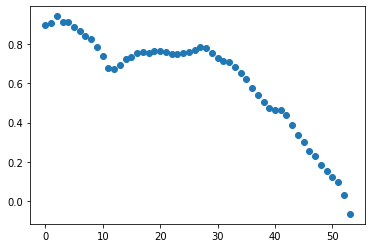

In [108]:
plt.plot(Ts, 'o')

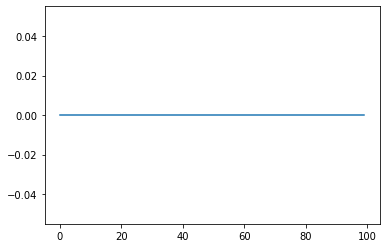

In [111]:
plt.plot(grads)

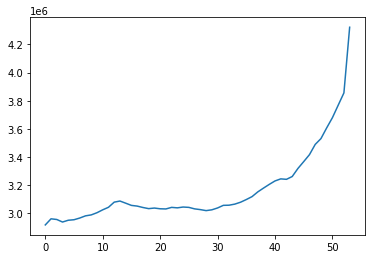

In [107]:
plt.plot(jnp.mean(jnp.array(av_energies), axis=1))